DECISION TREE
Nel file preprocessing_for_adult.py sono contenute le funzioni per il preprocessing da applicare ad adult.data: la prima (preprocessing_funct_not_enc) discretizza, normalizza ecc mentre la seconda (encoding_funct) esegue l'encoding.

In [1]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_and, K_subgroups_dataset_and_or, metrics_to_compare, preprocessing_funct_not_enc_SMOTE, encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import torch


from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor
from divexplorer.outcomes import get_false_positive_rate_outcome


In [2]:
torch.manual_seed(42)
seed = 42
pd.options.display.float_format = '{:.3f}'.format

In [3]:
pruning = 0.01

In [4]:
min_sup = 0.2
percentage = 10


In [5]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)

In [6]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [7]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


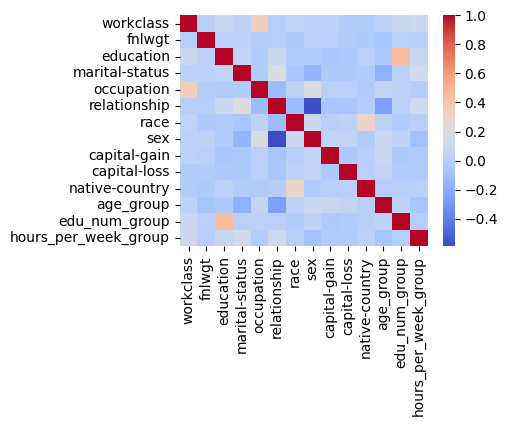

In [8]:
df_train_no_income = df_train_enc.drop(columns = 'income')
plt.figure(figsize=(4, 3))
g = sns.heatmap(df_train_no_income.corr(),
                annot = False,
                cmap = "coolwarm")


In [9]:
#DECISION TREE CLASSIFIER
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = DecisionTreeClassifier(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()


In [10]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [11]:
#predizioni per il validation set, queste mi servono solo per il div explorer che ha bisogno di ground truth e predizioni
y_pred_val = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [12]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

df_val_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_val['fp'] = df_val_class['fp']

#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['accuracy'] = (df_val_class['y_val_true']==df_val_class['y_pred']).astype(int)
df_val.head()


,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,fp,y_pred,accuracy
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,0.000,0,1
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,NaN,0,0
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,0.000,0,1
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,NaN,1,1
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,0.000,0,1


ANALISI CONDOTTA CON LA FEATURE FP (PASSATA A BOOLEAN OUTCOME)

In [13]:
fp_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by=["fp_div", "fp_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,fp,fp_div,fp_t,length,support_count
0,0.239,"(capital-loss=0.0, relationship= Husband, marital-status=Married, hours_per_week_group=Overtime, sex= Male, race= White, capital-gain=0.0, native-country=United-States)",0.362,0.224,13.300,8,1554.000
1,0.239,"(capital-loss=0.0, relationship= Husband, hours_per_week_group=Overtime, sex= Male, race= White, capital-gain=0.0, native-country=United-States)",0.362,0.224,13.300,7,1554.000
2,0.239,"(capital-loss=0.0, relationship= Husband, marital-status=Married, hours_per_week_group=Overtime, race= White, capital-gain=0.0, native-country=United-States)",0.362,0.224,13.300,7,1554.000
3,0.239,"(capital-loss=0.0, relationship= Husband, hours_per_week_group=Overtime, race= White, capital-gain=0.0, native-country=United-States)",0.362,0.224,13.300,6,1554.000
4,0.259,"(relationship= Husband, hours_per_week_group=Overtime, sex= Male, race= White, capital-gain=0.0, native-country=United-States)",0.361,0.223,13.527,6,1686.000


In [14]:
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()

,support,itemset,length,support_count,fp,fp_div,fp_t
16,0.297,"(hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, race= White)",4,1931.000,0.353,0.214,13.450
28,0.326,"(hours_per_week_group=Overtime, native-country=United-States, marital-status=Married, race= White)",4,2124.000,0.349,0.211,13.859
69,0.353,"(hours_per_week_group=Overtime, native-country=United-States, marital-status=Married)",3,2299.000,0.339,0.201,13.841
84,0.356,"(hours_per_week_group=Overtime, relationship= Husband)",2,2318.000,0.335,0.196,13.694
138,0.401,"(hours_per_week_group=Overtime, marital-status=Married)",2,2612.000,0.325,0.186,13.881


In [15]:
# Numero totale di istanze
total_instances = len(df_pruned_fp)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_fp[(df_pruned_fp['fp_div'] > 0) & (df_pruned_fp['fp_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 58
total problematic 34


In [16]:
prun_size = df_pruned_fp.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)


Dim original:  (893, 7)
Dim pruned th_redundancy  (58, 7)


In [17]:
K = int((percentage / 100) * filtered_instances)
K

3

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [18]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_holdout, K) #da aggiungere a train set e ripetere train e test
df_holdout_filtered_solo0 = df_holdout_filtered[df_holdout_filtered['income']==0]



df_combinated = pd.concat([df_holdout_filtered_solo0, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)

df_holdout_filtered = df_holdout_filtered_solo0 


In [19]:
print(len(df_holdout_filtered))

1252


In [20]:
'''#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, df_test_enc_filtered_fp, df_filtered_enc, df_val_enc_mit = encoding_funct(df_train=df_train_mitigated, df_test=df_test_filtered_fp, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc_mit.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", df_filtered_enc.shape[0])
print(f"TEST SET FILTERED ROWS: ", df_test_enc_filtered_fp.shape[0])'''

'#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati \ndf_train_enc_mit, df_test_enc_filtered_fp, df_filtered_enc, df_val_enc_mit = encoding_funct(df_train=df_train_mitigated, df_test=df_test_filtered_fp, df_holdout=df_holdout_filtered, df_val=df_val)\n#controllo divisione dataset\ndf_train_enc_mit_fp = df_train_enc_mit  \nprint(f"TRAIN SET ROWS: ", df_train_enc.shape[0])\nprint(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014\nprint(f"VALIDATION SET ROWS: ", df_val_enc_mit.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500\nprint(f"FILTERED DF holdout ROWS: ", df_filtered_enc.shape[0])\nprint(f"TEST SET FILTERED ROWS: ", df_test_enc_filtered_fp.shape[0])'

In [21]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  14266
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  1252
TEST SET FILTERED ROWS:  6507


In [22]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
#cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [23]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="income", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['income']

classifier_train_mitigated_random = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)



1252
verifica : 1252


In [24]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
"After Mitigation(K=5, fp)",0.813,0.592,0.108,0.436,533,684,14266,6508
After RANDOM mitigation,0.809,0.605,0.128,0.390,634,612,14266,6508


Performance su sottogruppi 


In [25]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_fp, df_test, K)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_random = classifier_train_mitigated_random.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_random)


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(y_train_mitigated_random), len(y_pred_test_filtered_fp_after_random)]
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Decision Tree performance when boolean outcomes = fp")
metrics_after_fp_sottogruppi

Subgroups Decision Tree performance when boolean outcomes = fp


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.660,0.644,0.317,0.365,388,421,13014,2376
"After Mitigation(K=5, on subgroups, fp)",0.680,0.641,0.233,0.412,285,475,14266,2376
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.670,0.654,0.305,0.357,373,412,14266,2376


ANALISI DIVERGENZE

Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [26]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation


In [27]:
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline1  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline1


In [28]:
#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_random_per_confrontare_con_baseline1


In [29]:
# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline1 = abs(sum(fp_div_list_baseline1) / len(fp_div_list_baseline1))
media_fp_div_list_baseline1_primi10 = abs(sum(fp_div_list_baseline1[:10]) / len(fp_div_list_baseline1[:10]))
media_fp_div_list_baseline1_primi20 = abs(sum(fp_div_list_baseline1[:20]) / len(fp_div_list_baseline1[:20]))
media_fp_div_list_baseline1_primi40 = abs(sum(fp_div_list_baseline1[:40]) / len(fp_div_list_baseline1[:40]))
fp_div_massimo_valore_assoluto_fp_div_baseline1 = max(abs(x) for x in fp_div_list_baseline1)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_fp_div_list_baseline1, fp_div_massimo_valore_assoluto_fp_div_baseline1,
        media_fp_div_list_baseline1_primi10, media_fp_div_list_baseline1_primi20, media_fp_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After Mitigation(K=5 fp),0.813,0.592,0.009,0.123,0.079,0.049,0.009,1252.000
After RANDOM Mitigation(K=5 fp),0.809,0.605,0.038,0.177,0.154,0.129,0.072,1252.000


BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE

SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

In [30]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fp', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)




Righe del dataset filtrato qunado K = 5 2610
numero di dati simulati con smotenc 2802
income
1    1401
0    1401
Name: count, dtype: int64


aggiungo una sampling strategy in modo da avere piu etichette = 0 visto che i sottogruppi porblematici hanno piu spesso etichette = 1 (per costruzione-per come ho impostato la ricerca dei sottogruppi)

In [31]:

'''sampling_strategy = {0: 2500, 1: 1400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print(len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)
'''

'sampling_strategy = {0: 2500, 1: 1400}\n\nsmote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)\nX_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\n\nprint(len(y_resampled))\n\nclass_counts = y_resampled.value_counts()\nprint(class_counts)\n'

In [32]:
X_train_mitigated_SMOTE = pd.concat([X_train, X_resampled], ignore_index=True)
y_train_mitigated_SMOTE = pd.concat([y_train, y_resampled], ignore_index=True)
print(len(X_train_mitigated_SMOTE))


15816


In [33]:
# X_test.head()  come verifica che tutto sia numerico 

In [34]:
classifier_train_mitigated_SMOTE = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_SMOTE.fit(X_train_mitigated_SMOTE, y_train_mitigated_SMOTE)
y_mitigated_SMOTE_pred = classifier_train_mitigated_SMOTE.predict(X_test)

In [35]:
'''#vediamo che succede se prendo lo stesso numero di righe ma random da holdout
print(len(X_resampled))
n_random_smote = len(X_resampled)

df_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)
print("verifica :", len(df_holdout_smote_sampled)) #verifica

df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)'''





'#vediamo che succede se prendo lo stesso numero di righe ma random da holdout\nprint(len(X_resampled))\nn_random_smote = len(X_resampled)\n\ndf_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)\nprint("verifica :", len(df_holdout_smote_sampled)) #verifica\n\ndf_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)\ndf_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)\n\nX_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)\ny_train_mitigated_random_smote = df_train_mitigated_random_smote[\'income\']\n\nclassifier_train_mitigated_random_smote = DecisionTreeClassifier(random_state=seed)\n\nclassifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)\ny_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)'

In [36]:
'''accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )
accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_pred)],
    'After RANDOM mitigation' : [accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random, len(y_train_mitigated_random_smote), len(y_mitigated_pred_random_smote)]
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)
    
metrics_after_fp_SMOTE'''


"accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )\naccuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )\n\n\nmetrics_after_fp_SMOTE = pd.DataFrame({\n    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],\n    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],\n    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_

A QUESTO PUNTO POSSIAMO VEDERE LE PERFORMANCE SUI SOTTOGRUPPI PRIMA E DOPO 

In [37]:
'''# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
y_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)
y_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)


#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )
accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_RANDOM_subgroups )

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM mitigation, on subgroups' : [accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE, len(y_train), len(y_pred_RANDOM_subgroups)],
    'After Mitigation(K=5, on subgroups, fp and SMOTE)': [accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_pred_test_filtered_fp_after_SMOTE)],
})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE


print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE'''

'# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima \ny_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)\ny_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)\n\n\n#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )\naccuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )\naccuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random

BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi positivi)
- FISSO p VARIA N 

In [38]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fp', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

Righe del dataset filtrato qunado K = 5 2610


In [39]:
count_1 = df_val_filtered['income'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(1209, 1401)

per confronto con targeted
N come len_df_holdout_filtered

In [40]:
p_values = np.arange(0.5, 1.05, 0.05)
p_values = np.round(p_values, 2).tolist()
p_values

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

N come holdout filtered e targeted acquisition

In [41]:
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi

N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 1252,0.809,0.605,0.128,0.390,634,612,14266,6508
After SMOTE N = 1252 p_class 0 = 0.5,0.804,0.599,0.134,0.393,661,616,14266,6508
After SMOTE N = 1252 p_class 0 = 0.55,0.802,0.590,0.132,0.408,650,640,14266,6508
After SMOTE N = 1252 p_class 0 = 0.6,0.805,0.597,0.129,0.401,639,628,14266,6508
After SMOTE N = 1252 p_class 0 = 0.65,0.808,0.602,0.126,0.399,621,626,14266,6508
After SMOTE N = 1252 p_class 0 = 0.7,0.802,0.589,0.131,0.411,647,644,14266,6508
After SMOTE N = 1252 p_class 0 = 0.75,0.804,0.590,0.126,0.415,624,651,14266,6508
After SMOTE N = 1252 p_class 0 = 0.8,0.807,0.593,0.123,0.415,608,650,14266,6508
After SMOTE N = 1252 p_class 0 = 0.85,0.808,0.594,0.121,0.416,598,652,14266,6508


In [42]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_confronto = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_confronto



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 1252,0.809,0.605,634,612,1246,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 1252 p_class 0 = 0.5,0.804,0.599,661,616,1277,0.052,0.201,0.181,0.150,0.084
After SMOTE N = 1252 p_class 0 = 0.55,0.802,0.590,650,640,1290,0.045,0.185,0.166,0.137,0.073
After SMOTE N = 1252 p_class 0 = 0.6,0.805,0.597,639,628,1267,0.041,0.182,0.161,0.131,0.072
After SMOTE N = 1252 p_class 0 = 0.65,0.808,0.602,621,626,1247,0.024,0.163,0.130,0.089,0.033
After SMOTE N = 1252 p_class 0 = 0.7,0.802,0.589,647,644,1291,0.012,0.164,0.104,0.065,0.018
After SMOTE N = 1252 p_class 0 = 0.75,0.804,0.590,624,651,1275,0.031,0.170,0.147,0.105,0.049
After SMOTE N = 1252 p_class 0 = 0.8,0.807,0.593,608,650,1258,0.032,0.170,0.149,0.099,0.036
After SMOTE N = 1252 p_class 0 = 0.85,0.808,0.594,598,652,1250,0.020,0.158,0.109,0.071,0.020


N  = 1000

In [43]:
# Dizionari per salvare i risultati
N = 1000
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi

original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 1000,0.806,0.603,0.132,0.389,652,610,14014,6508
After SMOTE N = 1000 p_class 0 = 0.5,0.809,0.609,0.129,0.385,638,603,14014,6508
After SMOTE N = 1000 p_class 0 = 0.55,0.810,0.609,0.127,0.387,629,607,14014,6508
After SMOTE N = 1000 p_class 0 = 0.6,0.806,0.604,0.134,0.385,660,603,14014,6508
After SMOTE N = 1000 p_class 0 = 0.65,0.804,0.598,0.133,0.394,659,618,14014,6508
After SMOTE N = 1000 p_class 0 = 0.7,0.806,0.598,0.128,0.401,633,629,14014,6508
After SMOTE N = 1000 p_class 0 = 0.75,0.806,0.595,0.126,0.409,623,641,14014,6508
After SMOTE N = 1000 p_class 0 = 0.8,0.811,0.605,0.123,0.397,610,623,14014,6508
After SMOTE N = 1000 p_class 0 = 0.85,0.813,0.602,0.115,0.413,567,648,14014,6508


In [44]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_1K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_1K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 1000,0.806,0.603,652,610,1262,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 1000 p_class 0 = 0.5,0.809,0.609,638,603,1241,0.048,0.191,0.171,0.142,0.081
After SMOTE N = 1000 p_class 0 = 0.55,0.810,0.609,629,607,1236,0.033,0.179,0.150,0.111,0.054
After SMOTE N = 1000 p_class 0 = 0.6,0.806,0.604,660,603,1263,0.048,0.195,0.173,0.141,0.082
After SMOTE N = 1000 p_class 0 = 0.65,0.804,0.598,659,618,1277,0.037,0.184,0.160,0.123,0.061
After SMOTE N = 1000 p_class 0 = 0.7,0.806,0.598,633,629,1262,0.030,0.179,0.149,0.106,0.051
After SMOTE N = 1000 p_class 0 = 0.75,0.806,0.595,623,641,1264,0.029,0.173,0.146,0.105,0.049
After SMOTE N = 1000 p_class 0 = 0.8,0.811,0.605,610,623,1233,0.018,0.145,0.112,0.070,0.018
After SMOTE N = 1000 p_class 0 = 0.85,0.813,0.602,567,648,1215,0.021,0.154,0.120,0.081,0.034


N = 2000

In [45]:
N = 2000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 2000,0.804,0.600,0.134,0.390,664,611,15014,6508
After SMOTE N = 2000 p_class 0 = 0.5,0.808,0.603,0.127,0.395,629,619,15014,6508
After SMOTE N = 2000 p_class 0 = 0.55,0.808,0.607,0.131,0.385,649,603,15014,6508
After SMOTE N = 2000 p_class 0 = 0.6,0.803,0.590,0.128,0.414,630,649,15014,6508
After SMOTE N = 2000 p_class 0 = 0.65,0.802,0.590,0.131,0.409,645,642,15014,6508
After SMOTE N = 2000 p_class 0 = 0.7,0.805,0.598,0.130,0.399,641,625,15014,6508
After SMOTE N = 2000 p_class 0 = 0.75,0.810,0.600,0.122,0.406,602,637,15014,6508
After SMOTE N = 2000 p_class 0 = 0.8,0.812,0.602,0.117,0.410,580,643,15014,6508
After SMOTE N = 2000 p_class 0 = 0.85,0.807,0.590,0.120,0.424,592,665,15014,6508


In [46]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_2K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_2K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 2000,0.804,0.600,664,611,1275,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 2000 p_class 0 = 0.5,0.808,0.603,629,619,1248,0.045,0.182,0.164,0.133,0.075
After SMOTE N = 2000 p_class 0 = 0.55,0.808,0.607,649,603,1252,0.051,0.193,0.175,0.154,0.091
After SMOTE N = 2000 p_class 0 = 0.6,0.803,0.590,630,649,1279,0.033,0.165,0.142,0.101,0.043
After SMOTE N = 2000 p_class 0 = 0.65,0.802,0.590,645,642,1287,0.035,0.178,0.145,0.100,0.035
After SMOTE N = 2000 p_class 0 = 0.7,0.805,0.598,641,625,1266,0.032,0.178,0.147,0.110,0.055
After SMOTE N = 2000 p_class 0 = 0.75,0.810,0.600,602,637,1239,0.020,0.169,0.120,0.080,0.026
After SMOTE N = 2000 p_class 0 = 0.8,0.812,0.602,580,643,1223,0.014,0.149,0.099,0.060,0.014
After SMOTE N = 2000 p_class 0 = 0.85,0.807,0.590,592,665,1257,0.014,0.149,0.100,0.062,0.014


N = 3000

In [47]:
N = 3000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 3000,0.809,0.604,0.126,0.395,622,620,16014,6508
After SMOTE N = 3000 p_class 0 = 0.5,0.806,0.606,0.135,0.379,668,595,16014,6508
After SMOTE N = 3000 p_class 0 = 0.55,0.807,0.606,0.133,0.384,656,602,16014,6508
After SMOTE N = 3000 p_class 0 = 0.6,0.800,0.592,0.138,0.397,682,622,16014,6508
After SMOTE N = 3000 p_class 0 = 0.65,0.801,0.586,0.130,0.416,642,652,16014,6508
After SMOTE N = 3000 p_class 0 = 0.7,0.804,0.589,0.126,0.417,624,654,16014,6508
After SMOTE N = 3000 p_class 0 = 0.75,0.811,0.599,0.118,0.413,584,647,16014,6508
After SMOTE N = 3000 p_class 0 = 0.8,0.807,0.595,0.123,0.413,606,647,16014,6508
After SMOTE N = 3000 p_class 0 = 0.85,0.807,0.585,0.117,0.434,577,681,16014,6508


In [48]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_3K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_3K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 3000,0.809,0.604,622,620,1242,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 3000 p_class 0 = 0.5,0.806,0.606,668,595,1263,0.043,0.191,0.169,0.139,0.077
After SMOTE N = 3000 p_class 0 = 0.55,0.807,0.606,656,602,1258,0.037,0.184,0.158,0.124,0.065
After SMOTE N = 3000 p_class 0 = 0.6,0.800,0.592,682,622,1304,0.019,0.174,0.127,0.082,0.028
After SMOTE N = 3000 p_class 0 = 0.65,0.801,0.586,642,652,1294,0.018,0.163,0.104,0.068,0.018
After SMOTE N = 3000 p_class 0 = 0.7,0.804,0.589,624,654,1278,0.041,0.168,0.152,0.117,0.057
After SMOTE N = 3000 p_class 0 = 0.75,0.811,0.599,584,647,1231,0.012,0.145,0.087,0.052,0.012
After SMOTE N = 3000 p_class 0 = 0.8,0.807,0.595,606,647,1253,0.020,0.152,0.114,0.073,0.020
After SMOTE N = 3000 p_class 0 = 0.85,0.807,0.585,577,681,1258,0.008,0.140,0.092,0.059,0.011


N = 4000

In [49]:
N = 4000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 4000,0.809,0.607,0.128,0.388,634,609,17014,6508
After SMOTE N = 4000 p_class 0 = 0.5,0.804,0.604,0.138,0.378,684,593,17014,6508
After SMOTE N = 4000 p_class 0 = 0.55,0.805,0.600,0.133,0.392,656,614,17014,6508
After SMOTE N = 4000 p_class 0 = 0.6,0.806,0.603,0.131,0.391,647,613,17014,6508
After SMOTE N = 4000 p_class 0 = 0.65,0.808,0.597,0.122,0.410,604,643,17014,6508
After SMOTE N = 4000 p_class 0 = 0.7,0.800,0.584,0.131,0.417,649,654,17014,6508
After SMOTE N = 4000 p_class 0 = 0.75,0.808,0.593,0.121,0.418,596,655,17014,6508
After SMOTE N = 4000 p_class 0 = 0.8,0.805,0.582,0.117,0.438,580,687,17014,6508
After SMOTE N = 4000 p_class 0 = 0.85,0.808,0.591,0.118,0.424,583,665,17014,6508


In [50]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_4K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_4K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 4000,0.809,0.607,634,609,1243,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 4000 p_class 0 = 0.5,0.804,0.604,684,593,1277,0.055,0.200,0.182,0.154,0.085
After SMOTE N = 4000 p_class 0 = 0.55,0.805,0.600,656,614,1270,0.032,0.185,0.150,0.109,0.050
After SMOTE N = 4000 p_class 0 = 0.6,0.806,0.603,647,613,1260,0.029,0.181,0.138,0.092,0.029
After SMOTE N = 4000 p_class 0 = 0.65,0.808,0.597,604,643,1247,0.045,0.178,0.158,0.137,0.081
After SMOTE N = 4000 p_class 0 = 0.7,0.800,0.584,649,654,1303,0.029,0.174,0.138,0.092,0.029
After SMOTE N = 4000 p_class 0 = 0.75,0.808,0.593,596,655,1251,0.012,0.152,0.103,0.066,0.017
After SMOTE N = 4000 p_class 0 = 0.8,0.805,0.582,580,687,1267,0.011,0.139,0.085,0.052,0.011
After SMOTE N = 4000 p_class 0 = 0.85,0.808,0.591,583,665,1248,0.007,0.143,0.090,0.054,0.007


N = 5000

In [51]:
N = 5000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.803,0.593,0.132,0.402,654,631,18014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.806,0.607,0.135,0.378,669,593,18014,6508
After SMOTE N = 5000 p_class 0 = 0.55,0.808,0.605,0.130,0.388,642,609,18014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.805,0.597,0.130,0.399,644,626,18014,6508
After SMOTE N = 5000 p_class 0 = 0.65,0.803,0.587,0.127,0.419,625,657,18014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.808,0.596,0.123,0.411,608,644,18014,6508
After SMOTE N = 5000 p_class 0 = 0.75,0.803,0.581,0.121,0.434,600,681,18014,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.805,0.584,0.119,0.432,590,677,18014,6508
After SMOTE N = 5000 p_class 0 = 0.85,0.809,0.584,0.112,0.442,553,693,18014,6508


In [52]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_5K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_5K


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 5000,0.803,0.593,654,631,1285,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 5000 p_class 0 = 0.5,0.806,0.607,669,593,1262,0.050,0.198,0.183,0.147,0.081
After SMOTE N = 5000 p_class 0 = 0.55,0.808,0.605,642,609,1251,0.043,0.180,0.161,0.130,0.072
After SMOTE N = 5000 p_class 0 = 0.6,0.805,0.597,644,626,1270,0.022,0.169,0.132,0.085,0.031
After SMOTE N = 5000 p_class 0 = 0.65,0.803,0.587,625,657,1282,0.037,0.177,0.148,0.109,0.047
After SMOTE N = 5000 p_class 0 = 0.7,0.808,0.596,608,644,1252,0.012,0.159,0.102,0.063,0.012
After SMOTE N = 5000 p_class 0 = 0.75,0.803,0.581,600,681,1281,0.022,0.157,0.118,0.075,0.022
After SMOTE N = 5000 p_class 0 = 0.8,0.805,0.584,590,677,1267,0.009,0.141,0.089,0.050,0.009
After SMOTE N = 5000 p_class 0 = 0.85,0.809,0.584,553,693,1246,0.013,0.133,0.084,0.047,0.013


N = 6000

In [53]:
N = 6000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 6000,0.807,0.605,0.132,0.386,651,606,19014,6508
After SMOTE N = 6000 p_class 0 = 0.5,0.799,0.592,0.140,0.394,693,618,19014,6508
After SMOTE N = 6000 p_class 0 = 0.55,0.800,0.592,0.138,0.397,680,623,19014,6508
After SMOTE N = 6000 p_class 0 = 0.6,0.809,0.608,0.130,0.385,642,603,19014,6508
After SMOTE N = 6000 p_class 0 = 0.65,0.808,0.599,0.125,0.404,617,633,19014,6508
After SMOTE N = 6000 p_class 0 = 0.7,0.807,0.591,0.121,0.420,599,659,19014,6508
After SMOTE N = 6000 p_class 0 = 0.75,0.807,0.586,0.118,0.432,581,678,19014,6508
After SMOTE N = 6000 p_class 0 = 0.8,0.809,0.591,0.116,0.427,573,670,19014,6508
After SMOTE N = 6000 p_class 0 = 0.85,0.804,0.576,0.116,0.448,571,703,19014,6508


In [54]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_6K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_6K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.054,0.190,0.172,0.153,0.097
After RANDOM mitigation N = 6000,0.807,0.605,651,606,1257,0.038,0.177,0.154,0.129,0.072
After SMOTE N = 6000 p_class 0 = 0.5,0.799,0.592,693,618,1311,0.024,0.191,0.142,0.093,0.031
After SMOTE N = 6000 p_class 0 = 0.55,0.800,0.592,680,623,1303,0.048,0.201,0.181,0.140,0.072
After SMOTE N = 6000 p_class 0 = 0.6,0.809,0.608,642,603,1245,0.036,0.181,0.151,0.109,0.046
After SMOTE N = 6000 p_class 0 = 0.65,0.808,0.599,617,633,1250,0.013,0.150,0.097,0.058,0.013
After SMOTE N = 6000 p_class 0 = 0.7,0.807,0.591,599,659,1258,0.015,0.157,0.104,0.064,0.015
After SMOTE N = 6000 p_class 0 = 0.75,0.807,0.586,581,678,1259,0.023,0.150,0.123,0.085,0.031
After SMOTE N = 6000 p_class 0 = 0.8,0.809,0.591,573,670,1243,0.015,0.140,0.102,0.060,0.015
After SMOTE N = 6000 p_class 0 = 0.85,0.804,0.576,571,703,1274,0.022,0.141,0.109,0.070,0.022


N = 7000

In [55]:
'''N = 7000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE'''

'N = 7000\n# Dizionari per salvare i risultati\nX_train_mit_SMOTE_dict = {}\ny_train_mit_SMOTE_dict = {}\ny_pred_SMOTE_dict = {}\nmetrics_results_compare = {}\nfp_div_results = {}  # Divergenza nei falsi positivi\n\n\noriginal_size = len(X_to_SMOTE)\n\nfor p in p_values:\n    # Definizione della strategia di campionamento\n    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}\n    \n    # Applicazione di SMOTENC\n    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)\n    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\n    \n    # Estrazione dei campioni generati\n    X_generated = X_sampled_SMOTE[-N:]\n    y_generated = y_sampled_SMOTE[-N:]\n    \n    # Creazione del dataset di training con SMOTE\n    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)\n    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index

In [56]:
'''# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_7K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_7K

'''

'# Dizionario per salvare i risultati della divergenza\nfp_div_results = {}\n\n# Lista degli esperimenti con l\'ordine desiderato\nexperiments = {\n    "no_mitigation": y_pred,  # Prima Before Mitigation\n    "random": y_mitigated_pred_random,  # Poi Random\n    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p\n}\n\n# Iteriamo su ogni esperimento nell\'ordine corretto\nfor exp_name, preds in experiments.items():\n    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni\n    if exp_name == "SMOTE":\n        iter_values = preds  # Lista dei valori di p\n    else:\n        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario\n\n    for p in iter_values:\n        # Creazione del DataFrame per il test set\n        df_test_class = X_test.copy()\n        df_test_class[\'y_test_true\'] = y_test\n        \n        # Se l\'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore\n        df

N = 8000

In [57]:
'''N = 8000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi

original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE'''

'N = 8000\n# Dizionari per salvare i risultati\nX_train_mit_SMOTE_dict = {}\ny_train_mit_SMOTE_dict = {}\ny_pred_SMOTE_dict = {}\nmetrics_results_compare = {}\nfp_div_results = {}  # Divergenza nei falsi positivi\n\noriginal_size = len(X_to_SMOTE)\n\nfor p in p_values:\n    # Definizione della strategia di campionamento\n    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}\n    \n    # Applicazione di SMOTENC\n    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)\n    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\n    \n    # Estrazione dei campioni generati\n    X_generated = X_sampled_SMOTE[-N:]\n    y_generated = y_sampled_SMOTE[-N:]\n    \n    # Creazione del dataset di training con SMOTE\n    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)\n    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=T

In [58]:
'''# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_8K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_8K

'''

'# Dizionario per salvare i risultati della divergenza\nfp_div_results = {}\n\n# Lista degli esperimenti con l\'ordine desiderato\nexperiments = {\n    "no_mitigation": y_pred,  # Prima Before Mitigation\n    "random": y_mitigated_pred_random,  # Poi Random\n    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p\n}\n\n# Iteriamo su ogni esperimento nell\'ordine corretto\nfor exp_name, preds in experiments.items():\n    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni\n    if exp_name == "SMOTE":\n        iter_values = preds  # Lista dei valori di p\n    else:\n        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario\n\n    for p in iter_values:\n        # Creazione del DataFrame per il test set\n        df_test_class = X_test.copy()\n        df_test_class[\'y_test_true\'] = y_test\n        \n        # Se l\'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore\n        df

N = 9000

In [59]:
'''N = 9000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi


original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE'''

'N = 9000\n# Dizionari per salvare i risultati\nX_train_mit_SMOTE_dict = {}\ny_train_mit_SMOTE_dict = {}\ny_pred_SMOTE_dict = {}\nmetrics_results_compare = {}\nfp_div_results = {}  # Divergenza nei falsi positivi\n\n\noriginal_size = len(X_to_SMOTE)\n\nfor p in p_values:\n    # Definizione della strategia di campionamento\n    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}\n    \n    # Applicazione di SMOTENC\n    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)\n    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\n    \n    # Estrazione dei campioni generati\n    X_generated = X_sampled_SMOTE[-N:]\n    y_generated = y_sampled_SMOTE[-N:]\n    \n    # Creazione del dataset di training con SMOTE\n    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)\n    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index

In [60]:
'''# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_9K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_9K
'''


'# Dizionario per salvare i risultati della divergenza\nfp_div_results = {}\n\n# Lista degli esperimenti con l\'ordine desiderato\nexperiments = {\n    "no_mitigation": y_pred,  # Prima Before Mitigation\n    "random": y_mitigated_pred_random,  # Poi Random\n    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p\n}\n\n# Iteriamo su ogni esperimento nell\'ordine corretto\nfor exp_name, preds in experiments.items():\n    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni\n    if exp_name == "SMOTE":\n        iter_values = preds  # Lista dei valori di p\n    else:\n        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario\n\n    for p in iter_values:\n        # Creazione del DataFrame per il test set\n        df_test_class = X_test.copy()\n        df_test_class[\'y_test_true\'] = y_test\n        \n        # Se l\'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore\n        df

N = 10000

In [61]:
'''N = 10000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}  # Divergenza nei falsi positivi

original_size = len(X_to_SMOTE)

for p in p_values:
    # Definizione della strategia di campionamento
    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}
    
    # Applicazione di SMOTENC
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    # Estrazione dei campioni generati
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    # Creazione del dataset di training con SMOTE
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    # Addestramento del modello
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    # Calcolo delle metriche
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    # Analisi della divergenza sui falsi positivi
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    
    # Calcolo falsi positivi
    y_trues = df_test_class["y_test_true"]
    y_preds = df_test_class["y_pred"]
    df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

    # Aggiunta delle feature calcolate a df_test
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']

    # Analisi della divergenza
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

    # Pruning della divergenza
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

    # Salvataggio della divergenza nel dizionario
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()


# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

# Creazione della tabella dei risultati
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE'''

'N = 10000\n# Dizionari per salvare i risultati\nX_train_mit_SMOTE_dict = {}\ny_train_mit_SMOTE_dict = {}\ny_pred_SMOTE_dict = {}\nmetrics_results_compare = {}\nfp_div_results = {}  # Divergenza nei falsi positivi\n\noriginal_size = len(X_to_SMOTE)\n\nfor p in p_values:\n    # Definizione della strategia di campionamento\n    sampling_strategy = {0: count_0 + int(N * p), 1: count_1 + int(N * (1 - p))}\n    \n    # Applicazione di SMOTENC\n    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)\n    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\n    \n    # Estrazione dei campioni generati\n    X_generated = X_sampled_SMOTE[-N:]\n    y_generated = y_sampled_SMOTE[-N:]\n    \n    # Creazione del dataset di training con SMOTE\n    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)\n    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=

In [62]:
'''# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_positive_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 0 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_10K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_10K
'''


'# Dizionario per salvare i risultati della divergenza\nfp_div_results = {}\n\n# Lista degli esperimenti con l\'ordine desiderato\nexperiments = {\n    "no_mitigation": y_pred,  # Prima Before Mitigation\n    "random": y_mitigated_pred_random,  # Poi Random\n    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p\n}\n\n# Iteriamo su ogni esperimento nell\'ordine corretto\nfor exp_name, preds in experiments.items():\n    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni\n    if exp_name == "SMOTE":\n        iter_values = preds  # Lista dei valori di p\n    else:\n        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario\n\n    for p in iter_values:\n        # Creazione del DataFrame per il test set\n        df_test_class = X_test.copy()\n        df_test_class[\'y_test_true\'] = y_test\n        \n        # Se l\'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore\n        df

In [63]:
K

3

salvo dati che mi servono

In [64]:
import json
import os

# Nome del file JSON
json_filename = "false_positives_K.json"

# Controlla se il file esiste già per evitare di sovrascrivere
if os.path.exists(json_filename):
    with open(json_filename, "r") as f:
        false_positives_data = json.load(f)
else:
    false_positives_data = {}

# Lista dei diversi metrics_after_fp_SMOTE_XK
metrics_dict = {
    "1K_run6": metrics_after_fp_SMOTE_1K,
    "2K_run6": metrics_after_fp_SMOTE_2K,
    "3K_run6": metrics_after_fp_SMOTE_3K,
    "4K_run6": metrics_after_fp_SMOTE_4K,
    "5K_run6": metrics_after_fp_SMOTE_5K,
    "6K_run6": metrics_after_fp_SMOTE_6K
}

# Iteriamo su ogni dataset e salviamo i falsi positivi
for J, metrics in metrics_dict.items():
    false_positives_data[f"N={J}"] = metrics["False Positives"].to_dict()

# Salviamo il JSON aggiornato
with open(json_filename, "w") as f:
    json.dump(false_positives_data, f, indent=4)

print(f"Dati salvati in {json_filename}")



#per i parametri # Nome del file JSON
json_filename = "false_positives_K.json"

# Valori da salvare (sostituiscili con i tuoi valori reali)
min_sup_run6 = min_sup
percentage_run6 = percentage
th_redundancy_run6 = pruning
K_run6 = K
L_run6 = filtered_instances  # Supponiamo sia la lunghezza di filtered_instances

# 1️⃣ Caricare i dati esistenti (se il file esiste)
try:
    with open(json_filename, "r") as f:
        false_positives_data = json.load(f)
except FileNotFoundError:
    false_positives_data = {}  # Se il file non esiste, inizializza un dizionario vuoto

# 2️⃣ Aggiungere le nuove variabili sotto una chiave dedicata
false_positives_data["run6_parameters"] = {
    "min_sup": min_sup_run6,
    "percentage": percentage_run6,
    "th_redundancy": th_redundancy_run6,
    "K": percentage,
    "L": L_run6
}

# 3️⃣ Salvare il file aggiornato
with open(json_filename, "w") as f:
    json.dump(false_positives_data, f, indent=4)

print("✅ Variabili salvate con successo in", json_filename)


Dati salvati in false_positives_K.json
✅ Variabili salvate con successo in false_positives_K.json


PLOT: andamento di falsi positivi e di falsi negativi al variare di N e p di appartenere alla classe 0

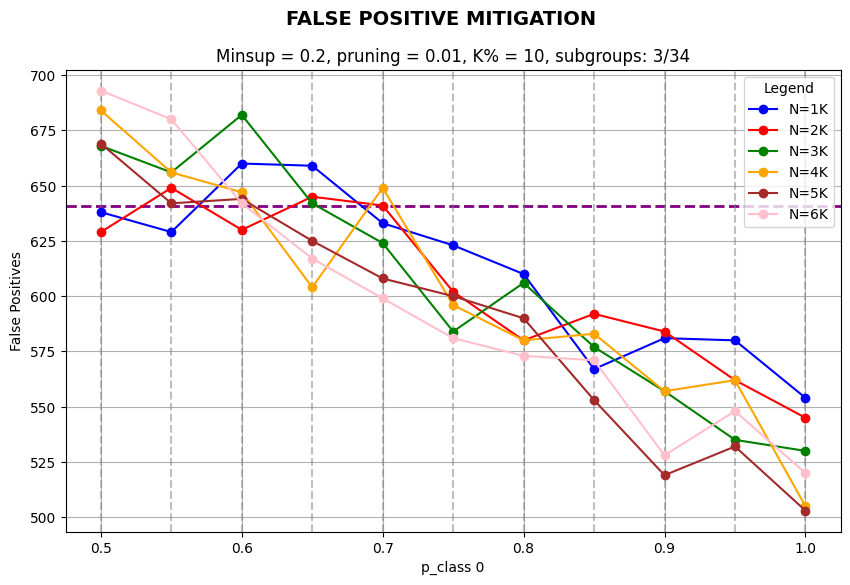

In [65]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Nome del file JSON
json_filename = "false_positives_K.json"

# Caricare i dati dal file JSON
with open(json_filename, "r") as f:
    false_positives_data = json.load(f)

# Estrarre parametri dal JSON
run6_params = false_positives_data.get("run6_parameters", {})
min_sup = run6_params.get("min_sup", "N/A")
percentage = run6_params.get("percentage", "N/A")
th_redundancy = run6_params.get("th_redundancy", "N/A")
L = run6_params.get("L", "N/A")
K = int((percentage / 100) * L)  # K rappresenta il numero di sottogruppi

# Lista dei valori di p da 0.5 a 1.0 con step 0.05
p_values = np.arange(0.5, 1.05, 0.05)

# Definiamo i colori per ogni N
colors = ["blue", "red", "green", "orange", "brown", "pink"]
labels = [f"N={k}K" for k in range(1, 7)]

# Creazione della figura
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("FALSE POSITIVE MITIGATION", fontsize=14, fontweight="bold")

# Disegniamo la linea tratteggiata "Before Mitigation"
before_mitigation = false_positives_data.get("N=1K_run6", {}).get("Before Mitigation", None)
if before_mitigation is not None:
    ax.axhline(y=before_mitigation, color="purple", linestyle="--", linewidth=2, label="Before Mitigation")

# Aggiungere linee verticali per ogni valore di p
for p in p_values:
    ax.axvline(x=p, color="gray", linestyle="--", alpha=0.5)

# Loop sui vari N (da 1K a 6K)
legend_handles = []
for i, n in enumerate(range(1, 7)):
    N_key = f"N={n}K_run6"
    if N_key not in false_positives_data:
        continue
    
    data = false_positives_data[N_key]
    
    # Estrarre i valori di falsi positivi per ogni p
    false_positives = [data.get(f"After SMOTE N = {n*1000} p_class 0 = {round(p, 2)}", None) for p in p_values]
    
    # Filtriamo solo i valori validi
    p_values_filtered = [p for j, p in enumerate(p_values) if false_positives[j] is not None]
    false_positives_filtered = [fp for fp in false_positives if fp is not None]
    
    # Plottiamo la linea corrispondente
    line, = ax.plot(
        p_values_filtered, false_positives_filtered, 
        marker="o", linestyle="-", color=colors[i], label=labels[i]
    )
    legend_handles.append(line)

# Impostazioni asse
ax.set_title(f"Minsup = {min_sup}, pruning = {th_redundancy}, K% = {percentage}, subgroups: {K}/{L}")
ax.set_xlabel("p_class 0")
ax.set_ylabel("False Positives")
ax.grid()

# Aggiungere la leggenda
ax.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True, title="Legend")

# Mostra il grafico
plt.show()